In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
# URL of the page to scrape
url = 'https://basketball.realgm.com/international/league/1/Euroleague/players'

# Send a GET request to fetch the page content
response = requests.get(url)
page_content = response.content

In [3]:
soup = BeautifulSoup(page_content, 'html.parser')

In [4]:
# Find the table body (tbody) and all rows (tr) within it
table_body = soup.find('tbody')
rows = table_body.find_all('tr')

players = []

# Loop through each row (tr) to get player data
for row in rows:
    # Extract player data from each row
    cells = row.find_all('td')
    
    # Extract player name from the first cell (assuming it is in an <a> tag)
    name_tag = cells[0].find('a')  # Player name is assumed to be in the first cell inside <a> tag
    if name_tag:
        player_name = name_tag.get_text(strip=True)
    else:
        player_name = "Unknown"  # Default if name is missing
    
    # Extract height from the third column (height)
    height = cells[2].get_text(strip=True)
    
    # Extract weight from the fourth column (weight)
    weight = cells[3].get_text(strip=True)

    # Store the player information
    players.append({
        'name': player_name,
        'height': height,
        'weight': weight
    })

# Print the scraped player data
# for i in range(0,10):
#     for player in players:
#         print(player)

In [5]:
# URL of the page to scrape for Player Stats
url = 'https://basketball.realgm.com/international/league/1/Euroleague/stats'

# Send a GET request to fetch the page content
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
page_content = response.content

In [6]:
# Grab the first stats table on the page (this is the main stats table)
table = soup.find('table')
if not table:
    raise Exception("Table not found on the page.")

# Get the table headers
thead = table.find('thead')
header_cells = thead.find_all('th')
column_names = [cell.get_text(strip=True) for cell in header_cells]

# Extract player rows
tbody = table.find('tbody')
rows = tbody.find_all('tr')

player_stats = []

for row in rows:
    cells = row.find_all('td')
    if len(cells) != len(column_names):
        continue  # skip rows that don't match

    player_data = {}
    for i, cell in enumerate(cells):
        if i == 0:
            # Extract name from <a> tag if available
            link = cell.find('a')
            player_data[column_names[i]] = link.get_text(strip=True) if link else cell.get_text(strip=True)
        else:
            player_data[column_names[i]] = cell.get_text(strip=True)
    player_stats.append(player_data)

# Print each player's stats
# for player in player_stats:
#     print(player)


In [7]:
# Convert height/weight data to a dictionary for faster lookup
height_weight_map = {player['name']: {'height': player['height'], 'weight': player['weight']} for player in players}

# Merge height and weight into the player_stats list
for stat in player_stats:
    name = stat['Player']
    if name in height_weight_map:
        stat['Height'] = height_weight_map[name]['height']
        stat['Weight'] = height_weight_map[name]['weight']
    else:
        stat['Height'] = 'N/A'
        stat['Weight'] = 'N/A'

# Optionally: create a DataFrame and export to CSV (ONLY TO TEST IT)
# df = pd.DataFrame(player_stats)
# df.to_csv('euroleague_player_stats_with_height_weight.csv', index=False)

# Or just print the merged data
# for player in player_stats:
#     print(player)


In [8]:
all_stats = []

for year in range(2024, 1999, -1):
    url = f'https://basketball.realgm.com/international/league/1/Euroleague/stats/{year}'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    table = soup.find('table')
    if not table:
        continue

    thead = table.find('thead')
    header_cells = thead.find_all('th')
    column_names = [cell.get_text(strip=True) for cell in header_cells]

    tbody = table.find('tbody')
    rows = tbody.find_all('tr')

    for row in rows:
        cells = row.find_all('td')
        if len(cells) != len(column_names):
            continue

        player_data = {'Season': year}
        for i, cell in enumerate(cells):
            text = cell.get_text(strip=True)
            if i == 0:
                link = cell.find('a')
                player_data[column_names[i]] = link.get_text(strip=True) if link else text
            else:
                player_data[column_names[i]] = text

        all_stats.append(player_data)


In [9]:
# Convert height/weight data to a dictionary for faster lookup
height_weight_map = {player['name']: {'height': player['height'], 'weight': player['weight']} for player in players}

# Merge height and weight into the all_stats list
for stat in all_stats:
    name = stat['Player']
    if name in height_weight_map:
        stat['Height'] = height_weight_map[name]['height']
        stat['Weight'] = height_weight_map[name]['weight']
    else:
        stat['Height'] = 'N/A'
        stat['Weight'] = 'N/A'

# Convert the combined data to a DataFrame
df = pd.DataFrame(all_stats)

# Drop any row with N/A values
df = df[~df.isin(['N/A']).any(axis=1)]

# Save the combined data to a CSV file
df.to_csv('latest_euroleague_player_stats_with_height_weight.csv', index=False)

# Optionally, print the DataFrame
# print(df)


In [10]:
# load output csv into dataframe
import pandas as pd
df = pd.read_csv("latest_euroleague_player_stats_with_height_weight.csv")
print(df.shape)
print(df.head())

# drop unnecessary columns
df = df.drop(columns=['Season', '#', 'Player', 'Team'])

# convert height to easier format
def height_to_inches(height_str):
    if isinstance(height_str, str) and '-' in height_str:
        feet, inches = map(int, height_str.split('-'))
        return feet * 12 + inches
    return height_str

df['Height'] = df['Height'].apply(height_to_inches)
print(df.shape)
print(df.head())

(836, 26)
   Season  #           Player  Team  GP   MPG   PPG  FGM   FGA    FG%  ...  \
0    2024  1    Markus Howard  BASK  39  23.0  19.5  6.5  15.1  0.431  ...   
1    2024  2       Mike James   ASM  39  31.7  17.9  5.9  13.9  0.426  ...   
2    2024  3  Wade Baldwin IV   MAC  30  27.6  17.4  5.7  12.4  0.456  ...   
3    2024  4     Keenan Evans   ZAL  34  27.4  17.3  5.5  11.5  0.481  ...   
4    2024  5   Nikola Mirotic   MIL  21  26.5  16.9  5.4  10.2  0.526  ...   

   ORB  DRB  RPG  APG  SPG  BPG  TOV   PF  Height  Weight  
0  0.3  0.9  1.2  1.6  0.5  0.0  1.9  2.7    5-11     180  
1  0.5  3.6  4.1  5.1  1.2  0.1  2.1  1.8     6-1     190  
2  0.3  2.2  2.5  4.9  1.0  0.2  2.6  1.9     6-4     220  
3  0.5  2.3  2.8  3.9  1.2  0.1  2.3  2.4     6-3     190  
4  1.8  3.9  5.7  0.9  0.8  0.3  1.7  2.2    6-10     250  

[5 rows x 26 columns]
(836, 22)
   GP   MPG   PPG  FGM   FGA    FG%  3PM  3PA    3P%  FTM  ...  ORB  DRB  RPG  \
0  39  23.0  19.5  6.5  15.1  0.431  3.8  9.5  

In [11]:
# for the model
data_characteristics = {} 
# each entry will have this format -
#   "feature_name": {"mean":<num>,"stddev":<num>,"median":<num>,"iqr":<num>}

c:\Users\Melody\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Melody\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Melody\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Melody\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

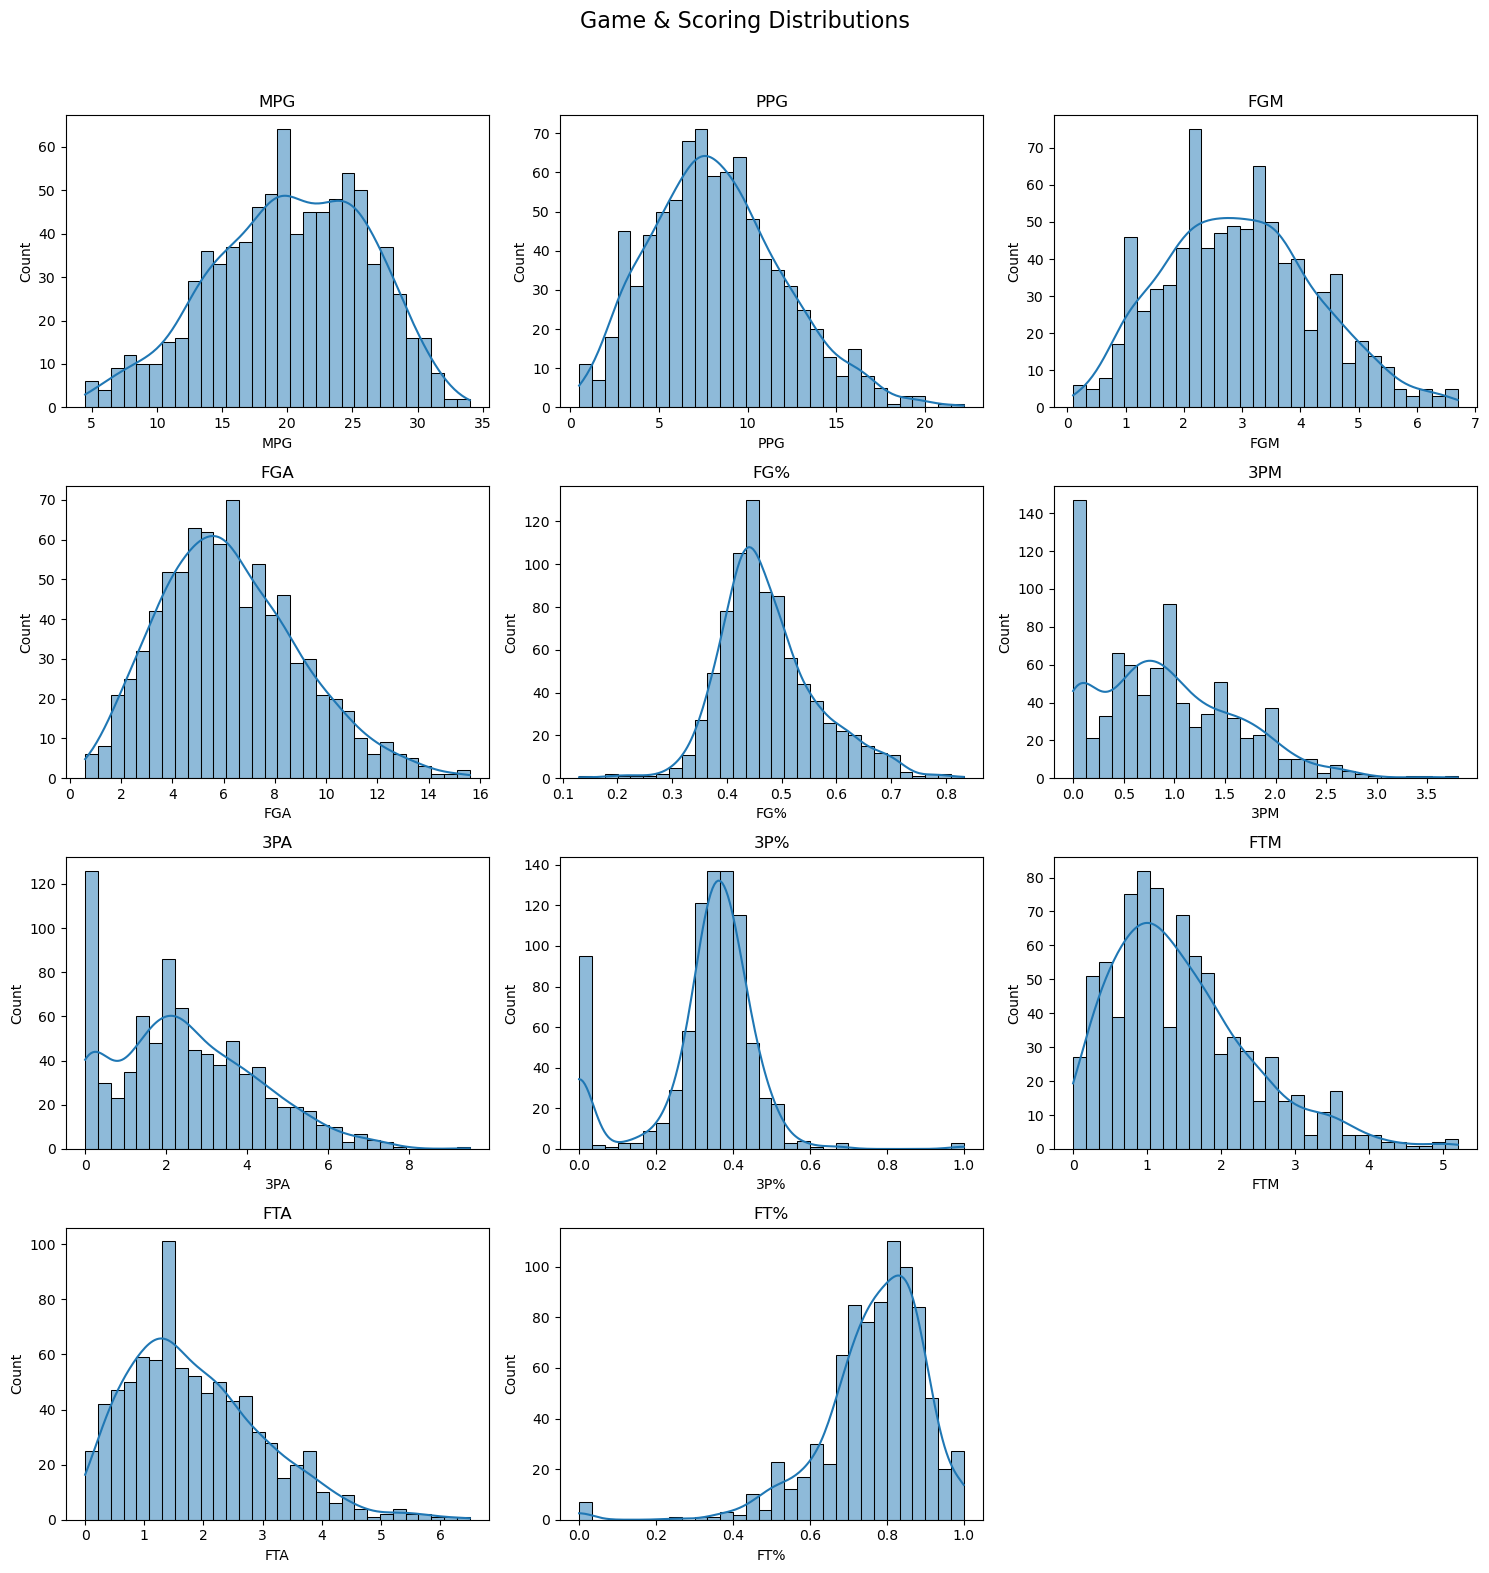

c:\Users\Melody\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Melody\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Melody\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Melody\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

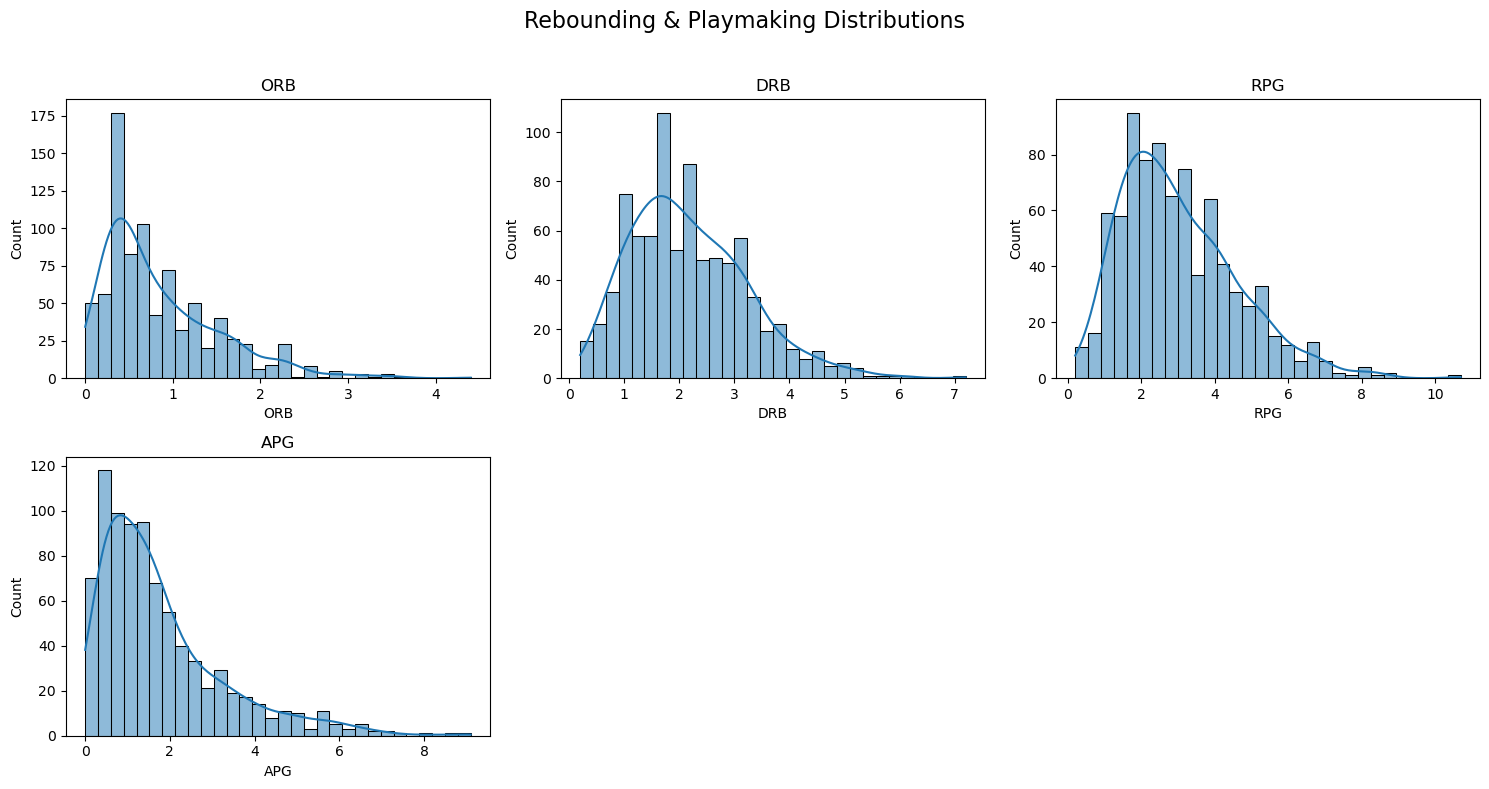

c:\Users\Melody\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Melody\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Melody\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Melody\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

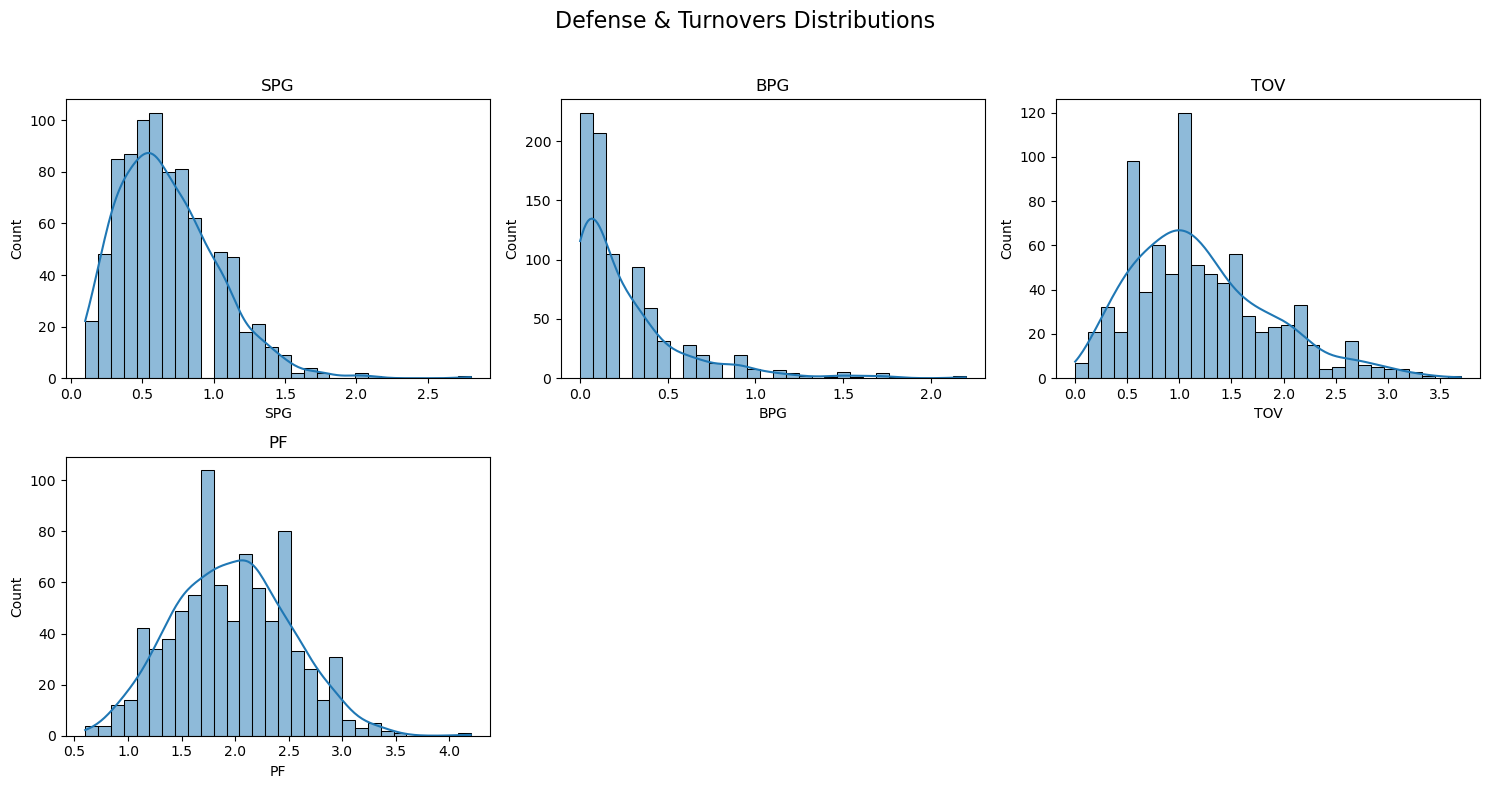

c:\Users\Melody\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Melody\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


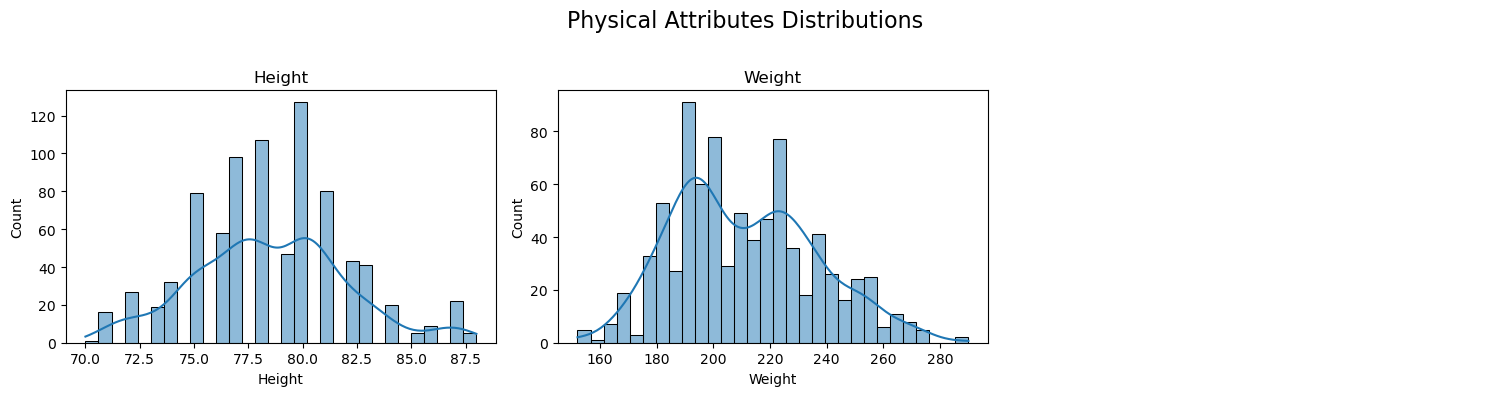

{'MPG': {'mean': 20.2122009569378, 'stddev': 5.933858551202223, 'median': 20.35, 'iqr': 8.9}, 'PPG': {'mean': 8.301435406698564, 'stddev': 3.7632350520397413, 'median': 8.0, 'iqr': 5.0}, 'FGM': {'mean': 2.9633971291866024, 'stddev': 1.2939009171559075, 'median': 2.9, 'iqr': 1.7999999999999998}, 'FGA': {'mean': 6.258851674641148, 'stddev': 2.726864466286176, 'median': 6.0, 'iqr': 3.8}, 'FG%': {'mean': 0.4764653110047847, 'stddev': 0.09059350543151658, 'median': 0.46, 'iqr': 0.10425000000000001}, '3PM': {'mean': 0.9165071770334928, 'stddev': 0.6864228205495371, 'median': 0.8, 'iqr': 0.9999999999999999}, '3PA': {'mean': 2.481818181818182, 'stddev': 1.7581780295718126, 'median': 2.3, 'iqr': 2.5}, '3P%': {'mean': 0.32605143540669856, 'stddev': 0.14223894372396606, 'median': 0.354, 'iqr': 0.10500000000000004}, 'FTM': {'mean': 1.4590909090909092, 'stddev': 0.9593915918206591, 'median': 1.3, 'iqr': 1.225}, 'FTA': {'mean': 1.8698564593301437, 'stddev': 1.1528565837625657, 'median': 1.7, 'iqr': 

In [12]:
# plot attributes

import matplotlib.pyplot as plt
import seaborn as sns

groups = {
    "Game & Scoring": ['MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%'],
    "Rebounding & Playmaking": ['ORB', 'DRB', 'RPG', 'APG'],
    "Defense & Turnovers": ['SPG', 'BPG', 'TOV', 'PF'],
    "Physical Attributes": ['Height', 'Weight']
}

# plot each group in a grid
for group_name, features in groups.items():
    n_cols = 3
    n_rows = (len(features) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    fig.suptitle(f'{group_name} Distributions', fontsize=16)
    axes = axes.flatten()

    for i, col in enumerate(features):
        # make plot
        sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
        axes[i].set_title(col)

        # save mean, stddev, median, IQR of feature
        data_characteristics[col] = {
            "mean": df[col].mean(), 
            "stddev": df[col].std(), 
            "median": df[col].median(), 
            "iqr": df[col].quantile(0.75)-df[col].quantile(0.25)
        }

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# for feature, characteristics in data_characteristics:
    # print(feature, ":", characteristics)
print(data_characteristics)

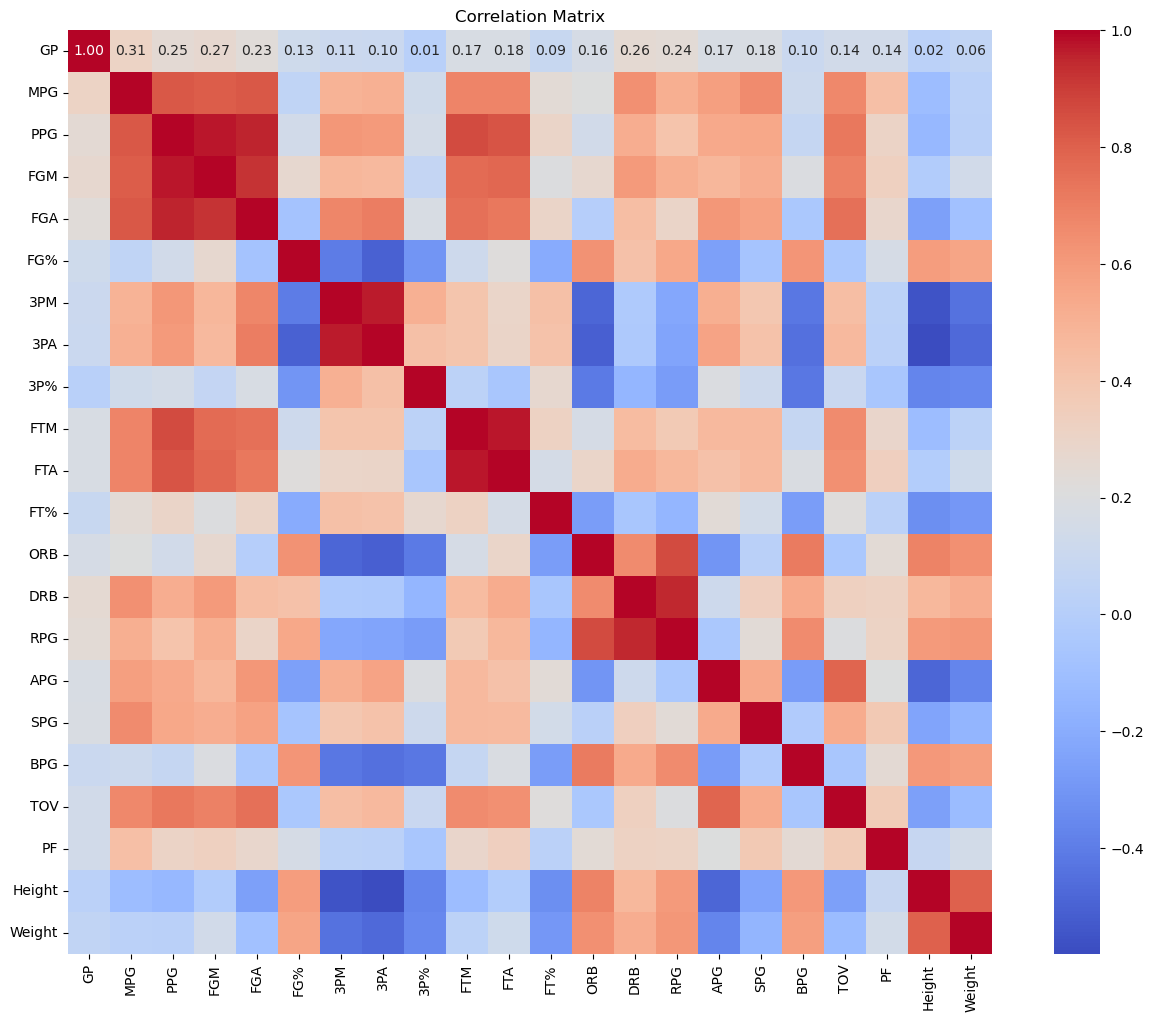

In [13]:
plt.figure(figsize=(16, 12))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

In [14]:
import pandas as pd

# Example weights between 0 and 1 for feature importance
weights = {
    'MPG': 0.3,     # Small signal of coach trust, not much for 1v1. mp column
    'PPG': 1.0,     # Strongest weight – scoring is everything take # of games and convert to pts/game
    'FGM': 0.8,     # Volume scoring # fg
    'FGA': 0.6,     # Volume attempts – shows aggressiveness #fga
    'FG%': 0.9,     # Efficient shooting is key #fg_percent
    '3PM': 0.7,     # Making threes gives space #x3p
    '3PA': 0.5,     # Attempts show range
    '3P%': 0.8,     # Accuracy from 3 is crucial
    'FTM': 0.1,     # Barely matters
    'FTA': 0.1,     # Same
    'FT%': 0.2,     # Same
    'ORB': 0.4,     # Second chances
    'DRB': 0.4,     # Defensive control
    'RPG': 0.5,     # Overall rebounding ability
    'APG': 0.3,     # Passing not supefr relevant in 1v1, but can indicate ball-handling ability, IQ
    'SPG': 0.6,     # Shows defensive instincts
    'BPG': 0.7,     # Rim protection matters in 1v1
    'TOV': 0.1,     # Not very useful, but a very turnover-prone player might be exposed
    'PF': 0.0,      # Not used in 1v1
    'Height': 0.8,  # Major advantage in post or defense
    'Weight': 0.6   # Strength helps to hold position or bully
}


scaled_features = {}

for feature, w in weights.items():
    print(feature)
    print(w)
    # Get mean and stddev from the data_characteristics dictionary (created by Melody)
    mean = data_characteristics[feature]['mean']
    stddev = data_characteristics[feature]['stddev']

    # Avoid division by zero if stddev is zero (rare but possible)
    if stddev == 0:
        print(f"Warning: stddev for {feature} is zero, skipping scaling.")
        scaled = df[feature] * 0  # all zeros (no variation)
    else:
        # Calculate Z-score using precomputed mean and stddev
        z_score = (df[feature] - mean) / stddev

        # Multiply by weight to scale influence (0 to 1)
        scaled = z_score * w

    # Store the scaled feature with suffix '_scaled'
    scaled_features[f"{feature}_scaled"] = scaled

# Create a DataFrame of all players using containing all scaled features
df_scaled = pd.DataFrame(scaled_features)

df_scaled["score"] = df_scaled.sum(axis=1)
df_scaled.to_csv("Training_Data.csv")
# Optional: inspect the first few rows of the scaled data
print(df_scaled.head())
print(data_characteristics['MPG']['mean'])
print(data_characteristics['MPG']['stddev'])
print(df_scaled["score"].head())

MPG
0.3
PPG
1.0
FGM
0.8
FGA
0.6
FG%
0.9
3PM
0.7
3PA
0.5
3P%
0.8
FTM
0.1
FTA
0.1
FT%
0.2
ORB
0.4
DRB
0.4
RPG
0.5
APG
0.3
SPG
0.6
BPG
0.7
TOV
0.1
PF
0.0
Height
0.8
Weight
0.6
   MPG_scaled  PPG_scaled  FGM_scaled  FGA_scaled  FG%_scaled  3PM_scaled  \
0    0.140944    2.975781    2.186630    1.945344   -0.451675    2.940527   
1    0.580792    2.550615    1.815659    1.681304   -0.501347    1.308880   
2    0.373507    2.417751    1.692002    1.351255   -0.203312    0.493056   
3    0.363396    2.391178    1.568344    1.153225    0.045050    1.512836   
4    0.317894    2.284886    1.506516    0.867182    0.492102    1.308880   

   3PA_scaled  3P%_scaled  FTM_scaled  FTA_scaled  ...  DRB_scaled  \
0    1.995868    0.415912    0.118920    0.115378  ...   -0.476286   
1    1.000519    0.258430    0.243999    0.262838  ...    0.540428   
2    0.346433    0.365293    0.327386    0.314882  ...    0.013243   
3    0.886765    0.612764    0.243999    0.202119  ...    0.050899   
4    0.773011 

In [20]:
import math
import pandas as pd
from sklearn.model_selection import train_test_split

# Features for our ML model
features = [
    'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%',
    'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF', 'Height', 'Weight'
]


# Load the EuroLeague z-scaled dataset
# df_scaled = pd.read_csv('latest_euroleague_player_stats_scaled.csv')

# Now split EuroLeague into 70% training and 30% validation as that is our training data and we plan to do 70-30 splits
# euroleague_train = df_scaled.sample(frac=0.7, random_state=42)
# euroleague_val = df_scaled.drop(euroleague_train.index)


# Load the NBA unscaled data
nba_df = pd.read_csv('Player Totals_cleaned.csv')

# Load the Euroleague unscaled data
euroleague_raw = pd.read_csv('latest_euroleague_player_stats_with_height_weight.csv')  # ← Your unscaled data
# euroleague_train_raw = euroleague_raw.loc[euroleague_train.index]  # Match split by index

# Calculate required number of samples from each dataset based on 70:30 training:validation data ratio
num_data_scaler = 1 # should be in range 0-1. change value if we want to work with less data while maintaining the 70:30 ratio
num_euroleague_samples = math.ceil(len(euroleague_raw) * num_data_scaler)
num_nba_samples = math.ceil(num_euroleague_samples * (30/70))

# Sample from raw datasets
euroleague_train_raw = euroleague_raw.sample(n=num_euroleague_samples)
nba_train_raw = nba_df.sample(n=num_nba_samples)

print("euroleague data num rows: ", euroleague_raw.shape[0])
print("nba data num rows: ", nba_train_raw.shape[0])
print("70/30 = ", 70/30, ", training/test ratio: ", euroleague_raw.shape[0]/nba_train_raw.shape[0])

# Euroleague raw means and stds
mean = euroleague_train_raw[features].mean()
std = euroleague_train_raw[features].std()

# Scale NBA test data using EuroLeague's mean and std
nba_scaled = (nba_train_raw[features] - mean) / std

# Combine scaled features with player names, teams, or IDs
nba_scaled_full = nba_train_raw.copy()
nba_scaled_full[features] = nba_scaled

# Now nba_scaled_full is your properly scaled NBA test set
print("NBA test data has been scaled using EuroLeague training statistics.")


euroleague data num rows:  836
nba data num rows:  359
70/30 =  2.3333333333333335 , training/test ratio:  2.328690807799443


TypeError: Could not convert ['6-57-26-86-66-35-116-56-56-106-96-67-16-105-116-56-16-96-96-96-56-26-107-06-96-56-56-66-96-86-76-96-36-66-56-86-86-16-86-67-36-67-06-116-106-95-116-06-56-47-46-66-36-46-56-26-56-96-106-86-57-36-56-66-65-116-47-36-46-76-36-17-06-66-36-16-57-26-56-46-66-36-116-37-36-56-46-36-45-116-26-96-05-117-36-66-86-36-86-56-96-76-56-116-37-07-06-36-116-86-76-06-86-26-86-96-86-36-46-66-46-56-96-46-116-56-56-76-96-66-66-86-46-117-06-16-86-86-36-66-36-87-26-37-06-46-26-96-66-96-86-57-16-106-86-96-36-16-56-46-76-66-66-46-36-106-56-36-76-46-116-76-66-116-106-86-56-116-86-46-57-07-36-76-36-56-106-86-106-66-56-17-37-26-105-116-76-87-26-66-116-77-46-96-46-96-36-46-66-46-86-66-96-17-06-06-76-66-96-46-116-36-37-06-86-86-86-36-06-36-106-56-116-86-96-66-66-86-76-56-96-66-36-66-56-36-46-86-96-116-106-66-26-96-106-56-66-76-96-106-86-96-66-06-06-26-16-37-16-46-116-85-106-96-26-66-86-36-86-56-56-96-16-106-106-86-36-86-46-76-56-66-46-56-86-116-36-06-06-86-96-16-56-06-57-06-86-76-66-17-36-66-36-116-86-56-106-46-16-66-26-26-86-66-76-36-116-66-96-56-96-86-57-06-56-96-56-106-66-06-06-56-86-76-56-86-106-86-66-66-56-96-106-96-86-86-46-46-86-56-86-46-56-86-55-116-86-96-46-96-56-76-106-116-66-56-106-86-47-27-46-86-56-56-116-06-66-56-25-116-36-36-96-46-86-86-96-87-06-76-96-56-26-97-36-86-26-66-86-36-106-66-56-86-86-66-76-66-116-76-86-56-66-66-26-36-56-26-87-46-86-67-26-86-46-57-36-106-36-36-36-76-106-06-86-46-86-66-66-56-57-16-46-56-85-116-106-16-66-86-06-86-66-06-87-16-26-76-66-76-116-36-66-26-76-46-106-116-86-86-86-06-67-36-56-36-86-66-86-86-76-46-66-116-66-26-97-06-36-57-36-36-56-56-36-06-76-96-86-96-66-66-86-116-96-66-107-26-26-85-116-26-96-106-107-06-66-46-86-106-56-76-36-116-56-56-66-65-116-36-66-66-86-66-86-46-75-116-116-86-86-36-76-06-37-06-86-26-96-36-66-36-56-37-36-97-36-36-97-36-56-87-36-96-26-86-106-76-86-96-86-76-36-96-96-36-66-106-76-96-46-66-06-56-06-96-96-35-116-56-06-86-86-86-96-96-46-06-36-56-96-66-26-87-06-36-46-36-56-36-46-87-36-56-56-106-66-26-56-86-96-26-56-47-06-86-66-46-36-86-16-16-86-36-66-46-57-26-116-66-66-106-106-96-76-116-36-106-66-106-116-66-76-26-86-16-06-46-36-86-36-36-56-86-86-86-86-96-66-26-117-36-86-86-86-76-66-96-67-06-86-26-66-67-36-26-86-66-116-56-86-86-36-66-96-116-86-36-06-36-86-36-86-96-37-36-36-116-76-66-56-56-56-116-66-36-96-96-46-56-26-86-36-56-66-76-86-36-46-46-16-46-66-56-86-106-56-86-76-106-86-76-96-96-116-66-85-116-56-56-36-66-66-46-66-56-86-46-66-86-66-66-46-56-66-66-96-86-76-56-56-116-36-116-46-66-26-66-76-36-96-106-36-56-116-96-46-116-46-76-56-86-96-46-36-116-66-87-37-36-86-76-86-96-06-06-46-106-76-96-67-06-26-76-66-96-16-96-116-56-97-46-95-116-86-96-6'] to numeric